In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
import pandas as pd
import sys
import math 
import torch 
from torch.autograd import Variable
import torch.nn as nn

In [2]:
# function for getting data 

def getData(N,sigma):
    distribution_range = torch.distributions.uniform.Uniform(0,1)
    Z = torch.distributions.normal.Normal(0, sigma)
    X = distribution_range.sample(torch.Size([N])).unsqueeze(1)
    Y = torch.cos(2*math.pi*X)+Z.sample(torch.Size([N])).unsqueeze(1)
    return X,Y    

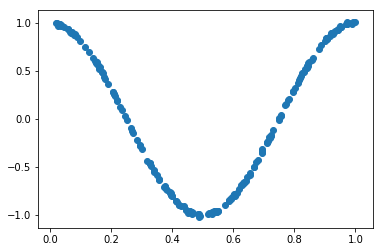

In [3]:
# GRAPH TO CHECK X AND Y 

N, sigma = 200, 0.01
X, Y = getData(N, sigma)

plt.scatter(X, Y)
plt.show()


In [4]:
# FUNCTION FOR GENRATING MEAN SQUARE ERROR

def getMSE(polynomial,X,Y):
    sample_size = Y.size()[0]
    loss = Y-polynomial(X)
    return (loss.norm().pow(2))/sample_size

In [5]:
# FITDATA FUNCTION

epochs = 10000
alpha = 0.01

def fitData(N,d,X,Y):
    theta_dist = torch.distributions.normal.Normal(0, 0.001)
    theta = torch.nn.Parameter(theta_dist.sample(torch.Size([d+1,1])))
    x_train = torch.cat([X ** i for i in range(0, d+1)], 1) 
    y_train = Y
    theta_grad_mask = torch.ones(torch.Size([d+1,1])) 
    theta_grad_mask[0] = 0
    
    itr_history = []
    mse_history = []
    
    def polynomial(X_array):
        return X_array.mm(theta)
    for epoch in range(0,epochs):
        mse = getMSE(polynomial, x_train, y_train)                                 
        mse.backward(retain_graph=True)
        weight_norm = theta.norm().pow(2)
        theta.data.sub_(alpha*theta.grad.data) 
        theta.grad.data.zero_()
        if lamb > 0.0 :
            weight_norm.backward(retain_graph=True)     
            theta.data.sub_(alpha*lamb*theta_grad_mask*theta.grad.data)
            theta.grad.data.zero_() 
        
        # saving history theta iteration
        itr_history.append(epoch)
        mse_history.append(mse.detach().numpy())
        
    Ein = getMSE(polynomial, x_train, y_train)
    X_test,Y_test=getData(2000,sigma)
    x_test = torch.cat([X_test ** i for i in range(0, d+1)], 1)
    Eout = getMSE(polynomial, x_test, Y_test)

    return polynomial, theta,Ein ,Eout ,[itr_history, mse_history] 

In [6]:
# EXPERIMENT FUNCTION

def experiment(N, d, sigma):
    M_trails   = 50
    E_in_bar  = 0.0
    E_out_bar = 0.0
    avg_theta = torch.zeros(d+1,1)
    for trial in range(0,M_trails):
        X, Y = getData(N, sigma)
        polynomial,theta,e_in,e_out,plot_data = fitData(N,d,X,Y)
        avg_theta   += theta
        E_in_bar += e_in       
        E_out_bar += e_out        
    E_in_bar = E_in_bar/M_trails
    E_out_bar = E_out_bar/M_trails 
    avg_theta = avg_theta/M_trails 
    X, Y = getData(2000, sigma)
    X = torch.cat([X ** i for i in range(0, d+1)], 1)
    Y_pred = X.mm(avg_theta) 
    E_bias =(Y_pred - Y).norm()**2/N
    return E_in_bar.detach().numpy(), E_out_bar.detach().numpy(), E_bias.detach().numpy()

In [7]:
# FUNCTION FORGENERATING GRAPHS

def generate_graph(N,D,S):
    i = 0
    combo = len(N)*len(D)*len(S)
    E_in_bar_arr = [0]*combo
    E_out_bar_arr =[0]*combo
    E_bias_arr = [0]*combo

    for n in N:
        for d in D:
            for s in S:
                E_in_bar, E_out_bar, E_bias = experiment(n,d,s)
            
                E_in_bar_arr[i] = E_in_bar
                E_out_bar_arr[i] = E_out_bar
                E_bias_arr[i] = E_bias
                i += 1
    return E_in_bar_arr, E_out_bar_arr, E_bias_arr  
  
  


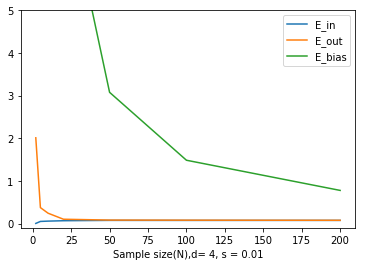

In [8]:
# GRAPH FOR ALL THE SAMPLE SIZES WITHOUT WEIGHT DECAY

lamb  = 0.0
N = [2, 5, 10, 20, 50, 100, 200]
D = [4]
S = [0.01]

E_in_bar_arr, E_out_bar_arr, E_bias_arr = generate_graph(N,D,S)

plt.plot(np.array(N).reshape(len(N),1), E_in_bar_arr, label = "E_in")
plt.plot(np.array(N).reshape(len(N),1), E_out_bar_arr, label = "E_out")
plt.plot(np.array(N).reshape(len(N),1), E_bias_arr, label = "E_bias")
plt.ylim((-0.1, 5))
plt.xlabel("Sample size(N),d= 4, s = 0.01")
plt.legend(loc="upper right")
plt.show()


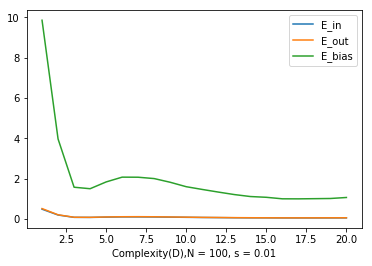

In [9]:
#GRAPH FOR ALL THE COMPLEXITIES WITHOUT WEIGHT DECAY

lamb  = 0.0
N = [100]
D = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
S = [0.01]

E_in_bar_arr, E_out_bar_arr, E_bias_arr = generate_graph(N,D,S)

#%%
plt.plot(np.array(D).reshape(len(D),1), E_in_bar_arr, label = "E_in")
plt.plot(np.array(D).reshape(len(D),1), E_out_bar_arr, label = "E_out")
plt.plot(np.array(D).reshape(len(D),1), E_bias_arr, label = "E_bias")
#plt.ylim((-0.1, 5))
plt.xlabel("Complexity(D),N = 100, s = 0.01")
plt.legend(loc="upper right")
plt.show()

In [0]:
# GRAPH FOR ALL THE NOISE VALUES WITHOUT WEIGHT DECAY

lamb  = 0.5
N = [100]
D = [4]
S = [0.01, 0.1, 1.0]

E_in_bar_arr, E_out_bar_arr, E_bias_arr = generate_graph(N,D,S)

plt.plot(np.array(S).reshape(len(S),1), E_in_bar_arr, label = "E_in")
plt.plot(np.array(S).reshape(len(S),1), E_out_bar_arr, label = "E_out")
plt.plot(np.array(S).reshape(len(S),1), E_bias_arr, label = "E_bias")
plt.xlabel("Noise(Sigma), N = 100, d = 4 ")
plt.legend(loc="upper right")
plt.show()

In [0]:
# WITHOUT WEIGHT DECAY

lamb  =0.0

N = [2, 5, 10, 20, 50, 100, 200]
D = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
S = [0.01, 0.1, 1.0]

all_combinatons = torch.Tensor(len(N)*len(D)*len(S),3)


i = 0;
for n in N:
    for d in D:
        for s in S:
            all_combinatons[i] = experiment(n,d,s)
            i = i + 1

Loss vs iterations:


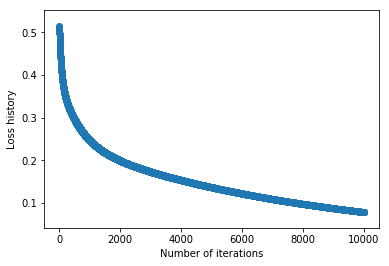

In [13]:
# LOSS OVER ITERATION GRAPH WITHOUT WEIGHT DECAY

lamb = 0.0

d = 10

polynomial,theta,e_in,e_out,plot_data = fitData(N,d,X,Y)


x, y = plot_data
print("Loss vs iterations:")
plt.scatter(x, y)
plt.xlabel("Number of iterations")
plt.ylabel("Loss history")
plt.show()

In [11]:
# EIN ,EOUT,EBIAS for different values of sigma

################################################
# for all the values of sigma

d = 9
sigma = 0.1
N = 200


E_in,E_out,E_bias = experiment(N, d, sigma)   
   

print(E_in,E_out,E_bias)

################################################
d = 9
sigma = 1 
N = 200

E_in,E_out,E_bias = experiment(N, d, sigma)   
   

print(E_in,E_out,E_bias)

################################################
d = 9
sigma = 0.01 
N = 200

E_in,E_out,E_bias = experiment(N, d, sigma)   
   

print(E_in,E_out,E_bias)



0.096544296 0.1003519 0.9971384
1.0572062 1.1079872 11.173285
0.08683858 0.09080243 0.8685065


In [0]:
# GENERATING ERRORS FOR ALL THE COMPLEXITIES

D = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
sigma = 0.1 
N = 200

i = 0
for d in D:

      E_in,E_out,E_bias = experiment(N, d, sigma)   
      i=i+1
      print(E_in,E_out,E_bias)




In [0]:
# GENERATING ERRORS FOR ALL THE COMBINATIONS OF SAMPLE SIZE
d = 6
sigma =0.1
N = [2, 5, 10, 20, 50, 100, 200]

i = 0
for n in N:

      E_in,E_out,E_bias = experiment(n, d, sigma)   
      i=i+1
      print(E_in,E_out,E_bias)


In [0]:
# FUNCTION WITH WEIGHT DECAY

lamb = 0.05

N = [2, 5, 10, 20, 50, 100, 200]
D = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
S = [0.01, 0.1, 1.0]

weight_decay = torch.Tensor(len(N)*len(D)*len(S),3)
i = 0;
for n in N:
    for d in D:
        for s in S:
          
            weight_decay[i] = experiment(n,d,s)
            
            i = i + 1

Loss vs iterations:


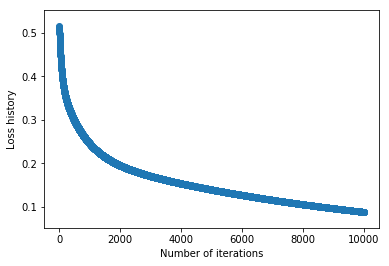

In [12]:
# LOSS OVER ITERATIONS OVER WEIGHT DECAY

polynomial,theta,e_in,e_out,plot_data = fitData(N,d,X,Y)


x, y = plot_data
print("Loss vs iterations:")
plt.xlabel("Number of iterations")
plt.ylabel("Loss history")
plt.scatter(x, y)
plt.show()

In [0]:
# GRAPH FOR ALL THE SAMPLE SIZES WITH WEIGHT DECAY

lamb  = 0.5
N = [2, 5, 10, 20, 50, 100, 200]
D = [4]
S = [0.01]

E_in_bar_arr, E_out_bar_arr, E_bias_arr = generate_graph(N,D,S)

plt.plot(np.array(N).reshape(len(N),1), E_in_bar_arr, label = "E_in")
plt.plot(np.array(N).reshape(len(N),1), E_out_bar_arr, label = "E_out")
plt.plot(np.array(N).reshape(len(N),1), E_bias_arr, label = "E_bias")
plt.ylim((-0.1, 5))
plt.xlabel("Sample size(N),d= 4, s = 0.01")
plt.legend(loc="upper right")
plt.show()


In [0]:
#GRAPH FOR ALL THE COMPLEXITIES WITH WEIGHT DECAY

lamb  = 0.5
N = [100]
D = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
S = [0.01]

E_in_bar_arr, E_out_bar_arr, E_bias_arr = generate_graph(N,D,S)

plt.plot(np.array(D).reshape(len(D),1), E_in_bar_arr, label = "E_in")
plt.plot(np.array(D).reshape(len(D),1), E_out_bar_arr, label = "E_out")
plt.plot(np.array(D).reshape(len(D),1), E_bias_arr, label = "E_bias")
#plt.ylim((-0.1, 5))
plt.xlabel("Complexity(D),N = 100, s = 0.01")
plt.legend(loc="upper right")
plt.show()

In [0]:
# GRAPH FOR ALL THE NOISE VALUES WITH WEIGHT DECAY

lamb  = 0.5
N = [100]
D = [4]
S = [0.01, 0.1, 1.0]

E_in_bar_arr, E_out_bar_arr, E_bias_arr = generate_graph(N,D,S)

plt.plot(np.array(S).reshape(len(S),1), E_in_bar_arr, label = "E_in")
plt.plot(np.array(S).reshape(len(S),1), E_out_bar_arr, label = "E_out")
plt.plot(np.array(S).reshape(len(S),1), E_bias_arr, label = "E_bias")
plt.xlabel("Noise(Sigma), N = 100, d = 4 ")
plt.legend(loc="upper right")
plt.show()